# Use: Tests of `BenamouBrenier.py`

In [16]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
from warnings import warn
from tqdm.notebook import tqdm,trange # to display loading bars
%load_ext autoreload
%autoreload 2

from BenamouBrenier import TransportProblem
from transport import gaussian_transport, gaussian_discreatization, random_gaussian_parameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
rng = np.random.default_rng(123)
from scipy.stats import multivariate_normal
from matplotlib.widgets import Slider
N=32
T=32
mesh= np.array(np.meshgrid(np.linspace(-5,5,N),np.linspace(-5,5,N)))

mean1, cov1 = random_gaussian_parameters(2,rng)
mean2, cov2 = random_gaussian_parameters(2,rng)

mu,nu = np.empty((N,N)),np.empty((N,N))
for idx in np.ndindex((N,N)):
    mu[idx] = multivariate_normal.pdf(mesh[(...,*idx)], mean1, cov1)
    nu[idx] = multivariate_normal.pdf(mesh[(...,*idx)], mean2, cov2)

prob1 = TransportProblem(mesh,mu,nu,T)
#%matplotlib
#prob1.plot()
#%matplotlib inline
#rob1.projection_step()
#prob1.dual_step()

TransportProblem object initialized.


## Todo
- check if code works for 1D ndarray with/without empty dimensions
- Use a package to compute poisson equation -> py-pde doesn't support 3D Poisson, Fenicsx doesn't explicitely support periodic bc, pure Neuman bc, numpy array data.

## Remarks
- **Projection Step**:
    - Analytic solution complicated and numerically instable. reduce the problem to 1D (grid-wise), and use Newton method to solve the polynomial equation of orthogonality. [Algorithms for projecting points onto conics](https://www.sciencedirect.com/science/article/pii/S0377042713001398#s000005)
    - choice of the initial point ([desmos graphic](https://www.desmos.com/calculator/nj6gcjfbaq)) to get the right zero.
- **Dual Step**: easy
- **Poisson Step**:
    - first order condition by calculus of variations, how to do it, and leads to weak poisson equation.
    - border conditions
    - https://fenicsproject.org can solve poisson equation, see [demo_poisson](https://docs.fenicsproject.org/dolfinx/v0.6.0/python/demos/demo_poisson.html)
- What is the Domain $\Omega\subset\mathbb{R}^d$, should contain the support of $\mu$ and $\nu$?
- gaussian transport
    - restrict to an ellipsis support of $\mu$ and renormalise (polar coord and 1D normal distribution)
    - the transport map is still optimal and lead to an ellipsis support, and is still optimal.

In [18]:
%matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.widgets import Slider


fig, (ax1,ax2) = plt.subplots(2)

s = Slider(ax = ax2, label = 'value', valmin = 0, valmax = N-1, valinit = 0)

def update(val):
    value=int(s.val)
    ax1.cla()
    ax1.contour(prob1.rho[value])

s.on_changed(update)
update(0)

plt.show()

Using matplotlib backend: MacOSX


## 3D Poisson solver
Solver of the 3D poisson equation with time Neumann heterogenous conditions and space periodic conditions.

In [19]:
from scipy import sparse
n = 3
Ad = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(n, n))
print(Ad.toarray())
Ap = Ad.toarray()
Ap[0,-1], Ap[-1,0] = 1, 1
Ap = sparse.dia_matrix(Ap)
print(Ap.toarray())
An = Ad.toarray()
An[0,1], An[-1,-2] = 2, 2
An = sparse.dia_matrix(An)
print(An.toarray())
I = sparse.eye(n)
A = sparse.kron(I,sparse.kron(I,An)) + sparse.kron(I,sparse.kron(Ap,I)) + sparse.kron(I,sparse.kron(I,Ap))
# print(A.toarray())

[[-2.  1.  0.]
 [ 1. -2.  1.]
 [ 0.  1. -2.]]
[[-2.  1.  1.]
 [ 1. -2.  1.]
 [ 1.  1. -2.]]
[[-2.  2.  0.]
 [ 1. -2.  1.]
 [ 0.  2. -2.]]


In [20]:
n=3
f = np.random.randint(0,10,size=(n,n,n))
g = np.random.randint(0,10, size=(2,n,n))
G = np.zeros((n,n,n))
G[[0,-1]] = g
print(G)
(np.arange(8).reshape((2,2,2),order="F")).flatten("F")

[[[6. 6. 5.]
  [6. 4. 8.]
  [2. 5. 6.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[3. 3. 6.]
  [6. 3. 6.]
  [2. 0. 2.]]]


array([0, 1, 2, 3, 4, 5, 6, 7])

In [26]:
def system_matrix(n):
    Ad = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(n, n))
    Ap = Ad.toarray()
    Ap[0,-1], Ap[-1,0] = 1, 1
    Ap = sparse.dia_matrix(Ap)
    An = Ad.toarray()
    An[0,1], An[-1,-2] = 2, 2
    An = sparse.dia_matrix(An)
    I = sparse.eye(n)
    A = sparse.kron(I,sparse.kron(I,An)) + sparse.kron(I,sparse.kron(Ap,I)) + sparse.kron(I,sparse.kron(I,Ap))
    return A

def extend(g):
    n = np.shape(g)[1]
    G = np.zeros((n,n,n))
    G[[0,-1]] = g
    return G

def normalize(A,b):
    n=len(b)
    one = sparse.bsr_matrix(np.ones((n,1)))
    A = sparse.vstack((A, one.T))
    one_zero = sparse.vstack((one, sparse.bsr_matrix([0])))
    A = sparse.hstack((A, one_zero))
    b = np.hstack((b, [0]))
    return A,b

/Users/benoitmuller/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


integral of u:            -56.0
integral of uex:          2.338709677419355
max-norm of the error:    8.996469123083973e+17


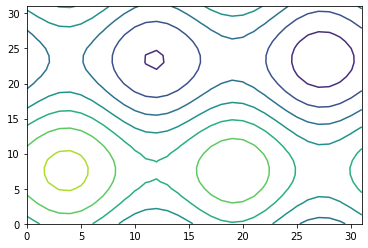

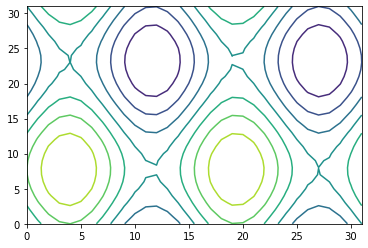

In [34]:
%matplotlib inline
n=32
uex = lambda x,y,z: 2 + x**2 + np.sin(2*np.pi*y) + np.sin(4*np.pi*z)
fex = lambda x,y,z: 2 - (2*np.pi)**2 * np.sin(2*np.pi*y) - (4*np.pi)**2 * np.sin(4*np.pi*z)
x=np.linspace(0,1,n)[:,None,None]
y=np.linspace(0,1,n)[None,:,None]
z=np.linspace(0,1,n)[None,None,:]
uex_vect = uex(x,y,z)
f = fex(x,y,z)
g = np.array([np.zeros((n,n)), 2*np.ones((n,n))])
A= system_matrix(n) / n**2
b = (f + 2*extend(g)/n).flatten("C")
A, b = normalize(A,b)
U = sparse.linalg.spsolve(A,b)
U= U[0:-1]
l = U[-1]
u = U.reshape((n,n,n),order="C")
print("integral of u:           ", np.sum(u)/n**3)
print("integral of uex:         ", np.sum(uex_vect)/n**3)
i=1
plt.contour(u[i,:,:])
plt.figure()
plt.contour(uex_vect[i,:,:])
print("max-norm of the error:   ", np.max(np.abs(u-uex_vect)))